# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import xgboost as xgb

### 0.0.1 Problema

Uma seguradora de planos de saúde pretende passar a vender, também, seguros de automóveis.

A seguradora realizou pesquisa com cerca de 380.000 clientes para saber se teriam interesse, ou não, em contratar o novo seguro. Todos os clientes responderam.

A seguradora selecionou cerca de 127.000 potenciais clientes para participar de uma campanha. Este grupo receberá a oferta de adesão ao seguro de automóvel via ligação telefônica.

**Problema**: o time de vendas tem condições de ligar para, somente, 20.000 pessoas. Como selecionar, dentre os potenciais clientes, aqueles que tem maior probabilidade de adquirir o seguro?

O *relatório* deve responder às seguintes questões:

1. Fornecer *insights* sobre os atributos mais relevantes de clientes interessados em adquirir o seguro.

2. Qual porcentagem dos potenciais clientes interessados o time de vendas vai conseguir contatar fazendo 20.000 ligações?

3. Se o time de vendas fizer 40.000 ligações, qual será a porcentagem de clientes interessados contatada?

4. Quantas ligações o time de vendas precisariaria fazer para contatar 80% dos potenciais clientes interessados?

## 0.1 Load Data

In [2]:
home_path = "/home/marcos/Documentos/comunidade_DS/pa004_health_insurance_cross_sell/"

In [3]:
df_test_raw = pd.read_csv(home_path + "data/test.csv")

In [4]:
df_test_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [5]:
df_validation = pd.read_pickle(home_path + "interim/df_new_val.pkl")

In [6]:
df_validation.isna().sum()

id                      0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
weight_ages             0
vehicle_hist            0
gender_Female           0
gender_Male             0
response                0
dtype: int64

In [7]:
cols_selected_boruta_resampled = pickle.load(open(home_path + "interim/cols_selected_boruta_resampled_new_nn.pkl", "rb"))

In [8]:
id_gender = ['id', 'gender_Female']
cols_selected_boruta_resampled_full = cols_selected_boruta_resampled.copy()
cols_selected_boruta_resampled_full.extend(id_gender)

In [9]:
col_resp = ['response']
cols_selected_boruta_resampled_resp = cols_selected_boruta_resampled_full.copy()
cols_selected_boruta_resampled_resp.extend(col_resp)

### 0.1.1 Load encoders

In [10]:
# age - RobustScaler
rs_age = pickle.load(open(home_path + "encoders/age_new_scaler.pkl", "rb"))

# region_code - frequency encoding
region_freq = pickle.load(open(home_path + "encoders/region_freq_new_scaler.pkl", "rb"))

# policy_sales_channel - frequency encoding
channel_freq = pickle.load(open(home_path + "encoders/channel_freq_new_scaler.pkl", "rb"))

# annual_premium - RobustScaler
rs_premium = pickle.load(open(home_path + "encoders/premium_new_scaler.pkl", "rb"))

# vintage - MinMaxScaler
mms_vintage = pickle.load(open(home_path + "encoders/vintage_new_scaler.pkl", "rb"))

# vehicle_age - LabelEncoder
age_encoder = pickle.load(open(home_path + "encoders/v_age_new_encoder.pkl", "rb"))

# vehicle_damage - LabelEncoder
damage_encoder = pickle.load(open(home_path + "encoders/v_dam_new_encoder.pkl", "rb"))

/home/marcos/.pyenv/versions/pa004_marcos_brum/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RobustScaler from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/marcos/.pyenv/versions/pa004_marcos_brum/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/marcos/.pyenv/versions/pa004_marcos_brum/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### 0.1.2 Load trained model

In [11]:
xgb_validated = pickle.load(open(home_path + "ml_models_comp/xgb_validated_new.pkl", "rb"))

## 0.2 Helper Functions

In [12]:
# model predict
def model_predict(trained_model, data_test):
    # drop id
    data_testing = data_test.drop(['id'], axis=1).copy()
    # predict_proba:
    yhat_proba = trained_model.predict_proba(data_testing)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = yhat_proba[:, 1].tolist()
    
    # include in dataframe
    testing_data = data_test.copy()
    testing_data['score'] = yhat_proba_1d
    # sort
    testing_data = testing_data.sort_values('score', ascending=False)
    # reset index
    testing_data.reset_index(drop=True, inplace=True)
    return testing_data


# precision_at_k, recall_at_k,
# precision_at_k
# def precision_at_k(data, k):
#     data = data.reset_index(drop=True)
#     data['n_samples'] = data.index + 1
#     data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
#     return data.loc[k, 'precision_at_k']


# # recall_at_k
# def recall_at_k(data, k):
#     data = data.reset_index(drop=True)
#     data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
#     return data.loc[k, 'recall_at_k']


# validation data
def validation_data(trained_model, data_val):
    # separate X and Y data:
    xval = data_val.drop(['id', 'response'], axis=1)
    yval = data_val.response
    
    # predict_proba:
    yhat_proba = trained_model.predict_proba(xval)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = yhat_proba[:, 1].tolist()
    
    # include in dataframe
    validation_data = data_val.copy()
    validation_data['score'] = yhat_proba_1d
    # sort
    validation_data = validation_data.sort_values('score', ascending=False)
    # precision and recall
    validation_data = validation_data.reset_index(drop=True)
    validation_data['n_samples'] = validation_data.index + 1
    validation_data['precision_at_k'] = validation_data['response'].cumsum() / validation_data['n_samples']
    validation_data['recall_at_k'] = validation_data['response'].cumsum() / validation_data['response'].sum()
    
    return validation_data


# validation metrics
def validation_metrics(validated_data, k):    
    return pd.DataFrame({'precision_at_{}'.format(k):validated_data.loc[k, 'precision_at_k'],
                         'recall_at_{}'.format(k):validated_data.loc[k, 'recall_at_k']},
                         index=['ranking_metrics']).T

## 0.3 Apply encoders and feature selection to data

In [13]:
df9 = df_test_raw.copy()

In [14]:
cols_list = df9.columns.tolist()
cols_lower = [x.lower() for x in cols_list]
df9.columns = cols_lower

In [15]:
df9.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
dtype: object

In [16]:
df9['region_code'] = df9['region_code'].astype(int)
df9['policy_sales_channel'] = df9['policy_sales_channel'].astype(int)

In [17]:
df9.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

In [18]:
def damage_map(damage):
    if damage == 'Yes':
        return 1
    else:
        return 0

In [19]:
vehicle_hist = df9['vehicle_damage'].map(damage_map) + 1 - df9['previously_insured']

In [20]:
df9.insert(loc=len(df9.columns)-1, column='vehicle_hist', value=vehicle_hist)

In [21]:
#gender: "One-hot" encoder
df9 = pd.get_dummies(df9, prefix='gender', columns=['gender'])

# age - RobustScaler
df9['age'] = rs_age.transform(df9[['age']].values)

# region_code - frequency encoding
df9['region_code'] = df9['region_code'].map(region_freq)

# policy_sales_channel - frequency encoding
df9['policy_sales_channel'] = df9['policy_sales_channel'].map(channel_freq)

# annual_premium - RobustScaler
df9['annual_premium'] = rs_premium.transform(df9[['annual_premium']].values)

# vintage - MinMaxScaler
df9['vintage'] = mms_vintage.transform(df9[['vintage']].values)

# vehicle_age - LabelEncoder
df9['vehicle_age'] = age_encoder.transform(df9['vehicle_age'])

# vehicle_damage - LabelEncoder
df9['vehicle_damage'] = damage_encoder.transform(df9['vehicle_damage'])

In [22]:
df9 = df9[cols_selected_boruta_resampled_full].copy()

In [23]:
df_validation = df_validation[cols_selected_boruta_resampled_resp].copy()

# 9.0 Business Performance

In [24]:
df_validated = validation_data(xgb_validated, df_validation)

## 9.1 Model Performance - metrics on validation

In [25]:
metrics = validation_metrics(df_validated, 20000)
metrics

,ranking_metrics
precision_at_20000,0.320234
recall_at_20000,0.685613


In [26]:
metrics = validation_metrics(df_validated, 40000)
metrics

,ranking_metrics
precision_at_40000,0.231669
recall_at_40000,0.991972


In [27]:
# separate X and Y data:
xval = df_validation.drop(['id', 'response'], axis=1)
yval = df_validation.response

# predict_proba:
yhat_proba = xgb_validated.predict_proba(xval)

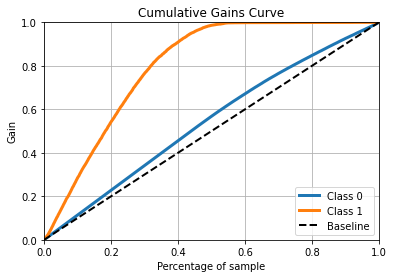

In [28]:
skplt.metrics.plot_cumulative_gain(yval, yhat_proba);

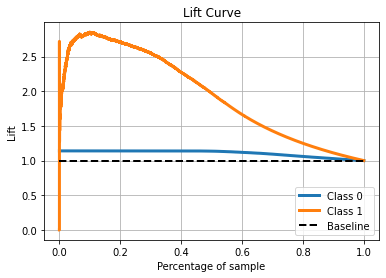

In [29]:
skplt.metrics.plot_lift_curve(yval, yhat_proba);

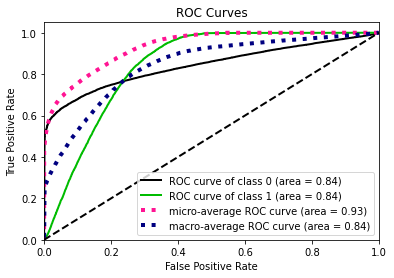

In [30]:
skplt.metrics.plot_roc(yval, yhat_proba);

### 9.1.1 80% of potentially interested

In [31]:
interested_80 = df_validated[df_validated['recall_at_k'] >= 0.8].index.min()
print('The marketing team will call 80% of the interested customers if they call {} people.'.format(interested_80))

The marketing team will call 80% of the interested customers if they call 24309 people.


## 9.2 Business performance

In [32]:
df9_predictions = model_predict(xgb_validated, df9)

In [33]:
df9_predictions

,age,policy_sales_channel,previously_insured,annual_premium,vintage,vehicle_hist,gender_Male,id,gender_Female,score
0,-0.428571,0.001831,0,5.480563,0.332180,2,1,465250,0,0.992677
1,-0.142857,0.001910,0,0.614371,0.387543,2,1,402420,0,0.992603
2,-0.238095,0.001910,0,-0.095367,0.449827,2,1,407285,0,0.991615
3,-0.047619,0.001882,0,0.742103,0.394464,2,1,396054,0,0.991526
4,-0.190476,0.001886,0,-0.137153,0.626298,2,1,482054,0,0.990970
...,...,...,...,...,...,...,...,...,...,...
127032,1.428571,0.156798,1,2.075183,0.349481,0,0,474611,1,0.000238
127033,1.857143,0.156798,1,1.183493,0.598616,0,0,443807,1,0.000236
127034,1.761905,0.156798,1,1.250917,0.377163,0,0,426280,1,0.000235
127035,1.904762,0.156798,1,1.235535,0.546713,0,0,398264,1,0.000230


In [34]:
df9_predictions.to_pickle(home_path + '/interim/predictions_nn_boruta_new.pkl')